In [3]:
# time series modeling
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
from scipy.stats import linregress

# np and pandas
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
# ggplot utilities
from plotnine import (ggplot, geom_line, xlab, ylab, ggtitle, aes, theme, 
                     geom_density, geom_histogram, after_stat, geom_ribbon, geom_smooth,
                      facet_wrap,  geom_point, scale_color_manual, scale_alpha_manual)

# loading ts data
from tsdata.raw import available_data, load_data

# set style of plots
plt.style.use('Solarize_Light2')

1. Simple Explonential Smooting
- No trend pattern
- No Seasonal pattern

In [4]:
global_economy_df = (load_data("global_economy")
 .assign(gdp_per_capita = lambda df: df.GDP / df.Population)
)

algeria_economy_df = global_economy_df[global_economy_df.Country == "Algeria"]
algeria_economy_ts = algeria_economy_df.set_index('Year').Exports

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


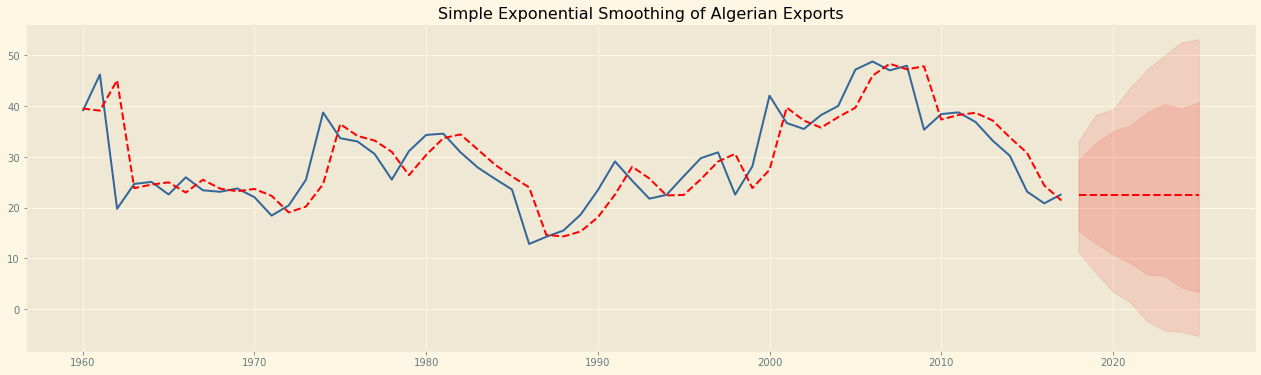

In [5]:
FORECAST_H = 8

# Simple Exponential Smoothing
ses_fitted = SimpleExpSmoothing(algeria_economy_ts).fit()

# forecast for the future 8 years
last_year = algeria_economy_ts.index.max()
forecast_x = np.arange(last_year + 1, last_year + FORECAST_H + 1)
forecast_y = ses_fitted.forecast(FORECAST_H).values

# start up the plot
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series data of algerian exports
ax.set_title("Simple Exponential Smoothing of Algerian Exports")
ax.plot(algeria_economy_ts, color="#336699")

# plot the forecast and the data
ax.plot(ses_fitted.fittedvalues, '--', lw=2, color='red')
ax.plot(forecast_x, forecast_y, '--', lw=2, color='red')

# plot confidence intervals by using mote carlo simulation
simulations = ses_fitted.simulate(8, repetitions=500)
lower = np.apply_along_axis(lambda x: np.quantile(x, 0.025), 1, simulations)
upper = np.apply_along_axis(lambda x: np.quantile(x, 0.975), 1, simulations)

# calculate 80% confidence interval
lower_80 = np.apply_along_axis(lambda x: np.quantile(x, 0.10), 1, simulations)
upper_80 = np.apply_along_axis(lambda x: np.quantile(x, 0.90), 1, simulations)

# plot the two confidence intervals
ax.fill_between(forecast_x, lower, upper, color='red', alpha=.1)
ax.fill_between(forecast_x, lower_80, upper_80, color='red', alpha=.1)

- If α is small (i.e., close to 0), more weight is given to observations from the more distant past.
- If α is large (i.e., close to 1), more weight is given to the more recent observations. For the extreme case where  $\alpha=1$ ,  $\hat{y}_{T+1|T}=y_T$, and the forecasts are equal to the naïve forecasts.

## Methods with trend

### Holt's Linear Trend Method

- Adds a trend to the smoothing equation
- Forecast equation $y_{t+h|t}=\mathcal{l}_t+hb_t$
- Level equation $\mathcal{l}_t=αy_t+(1−α)(\mathcal{l}_{t−1}+b_{t−1})$
- Trend equationt $β^*(\mathcal{l}_t−\mathcal{l}_{t−1})+(1−β^∗)b_{t−1},$

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: N

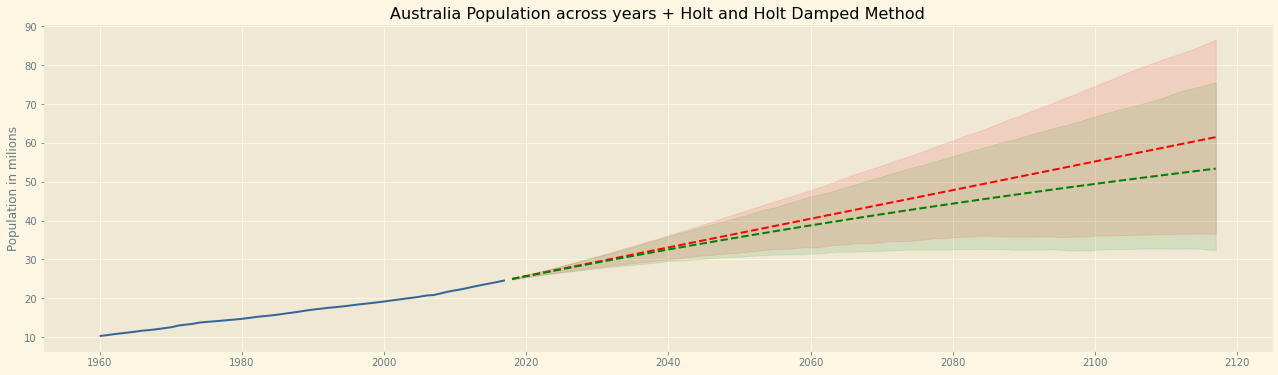

In [6]:
from statsmodels.tsa.api import Holt

aus_economy_df = (global_economy_df[global_economy_df.Code == "AUS"]
 .assign(Pop = lambda df: df.Population / 1e6)
)

aus_population_ts = aus_economy_df.set_index("Year").Pop


fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series data of algerian exports
ax.plot(aus_population_ts, color="#336699")
ax.set_title("Australia Population across years + Holt and Holt Damped Method")
ax.set_ylabel("Population in milions")

holt_fitted = Holt(aus_population_ts).fit()
holt_damped_fitted = Holt(aus_population_ts, damped_trend=True).fit()

FORECAST_H = 100

last_year = aus_population_ts.index.max()
forecast_x = np.arange(last_year + 1, last_year + FORECAST_H + 1)

# holt forecast
holt_forecast = pd.Series(
    holt_fitted.forecast(FORECAST_H).values, 
    forecast_x
)

# holt damped method forecast
holt_damped_forecast = pd.Series(
    holt_damped_fitted.forecast(FORECAST_H).values, 
    forecast_x
)

# simple holt method confidence intervals and simulations
simulations = holt_fitted.simulate(FORECAST_H, repetitions=1000)
lower = np.apply_along_axis(lambda x: np.quantile(x, 0.025), 1, simulations)
upper = np.apply_along_axis(lambda x: np.quantile(x, 0.975), 1, simulations)

# dampled method forecasts and confidence intervals
simulations_damped = holt_damped_fitted.simulate(FORECAST_H, repetitions=1000)
lower_damped = np.apply_along_axis(lambda x: np.quantile(x, 0.025), 1, simulations_damped)
upper_damped = np.apply_along_axis(lambda x: np.quantile(x, 0.975), 1, simulations_damped)

ax.plot(holt_forecast, '--', lw=2, color='red')
ax.plot(holt_damped_forecast, '--', lw=2, color='green')

# plot the two confidence intervals
ax.fill_between(forecast_x, lower, upper, color='red', alpha=.1)
ax.fill_between(forecast_x, lower_damped, upper_damped, color='green', alpha=.1)
# ax.fill_between(forecast_x, lower_80, upper_80, color='red', alpha=.1)

In [7]:
holt_fitted.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.3260971833076033,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 10.053003251878627,
 'initial_trend': 0.2239183664904775,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Methods with seasonality

### Holt-Winters’ additive method

### Example: Domestic overnight trips in Australia

Text(0, 0.5, 'Visitors (in millions)')

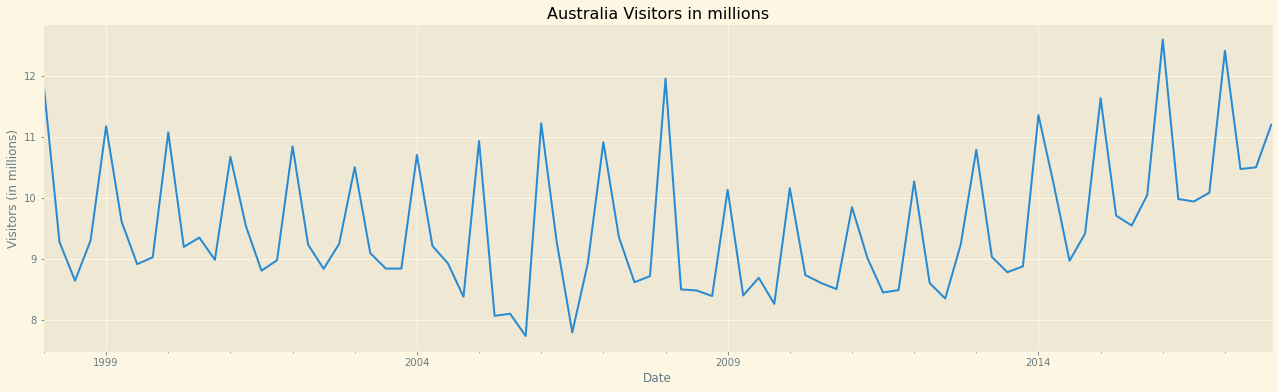

In [8]:
# forecast quarterly visitor nights in Australia spent by domestic tourists.
aus_tourism_df = load_data('tourism').assign(
    Date=lambda df: pd.to_datetime(
        df.Quarter.str.replace(" ", "-"))
    )
# aus_holidays_df = load_data("tourism")
aus_tourism_df = aus_tourism_df[aus_tourism_df.Purpose == "Holiday"].drop("Quarter", axis=1)


aus_trips_ts = aus_tourism_df.groupby("Date").sum()["Trips"] / 1e3
ax = aus_trips_ts.plot(figsize=(22, 6))

ax.set_title("Australia Visitors in millions")
ax.set_ylabel("Visitors (in millions)")

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.


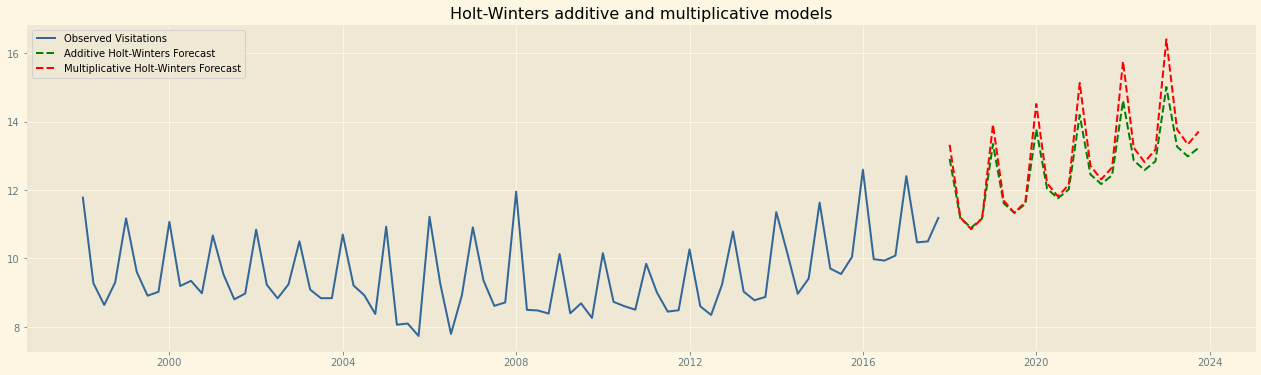

In [9]:
# Holt-Winters Additive Exponential Smoothing Model
hw_aus_trips_add_fitted = ExponentialSmoothing(
    aus_trips_ts,
    seasonal_periods=4,
    damped_trend=True,
    trend="add",
    seasonal="add",

    initialization_method="estimated"
).fit()

# Holt-Winters Multiplicative Exponential Smoothing Model
hw_aus_trips_mult_fitted = ExponentialSmoothing(
    aus_trips_ts,
    seasonal_periods=4,
    damped_trend=True,
    trend="mul",
    seasonal="mul",
    initialization_method="estimated"
).fit()


# holt additive and multiplicative forecasts
hw_aus_trips_add_forecast = hw_aus_trips_add_fitted.forecast(24)
hw_aus_trips_mult_forecast = hw_aus_trips_mult_fitted.forecast(24)

# plot the forecast and the data
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

ax.plot(aus_trips_ts, color="#336699")
ax.set_title("Holt-Winters additive and multiplicative models")

ax.plot(hw_aus_trips_add_forecast, '--', lw=2, color='green')
ax.plot(hw_aus_trips_mult_forecast, '--', lw=2, color='red')

ax.legend(["Observed Visitations", "Additive Holt-Winters Forecast", "Multiplicative Holt-Winters Forecast"])

In [10]:
hw_aus_trips_add_fitted.params
# hw can also be used for daily data

{'smoothing_level': 0.23310225936336096,
 'smoothing_trend': 0.1299706319618427,
 'smoothing_seasonal': 0.0,
 'damping_trend': 0.9949999999999971,
 'initial_level': 9.812545316533773,
 'initial_trend': -0.02574222363392208,
 'initial_seasons': array([ 1.56151082, -0.27886478, -0.66473649, -0.50940693]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}


 Short hand      | Method |
| ----------- | ----------- |
| $(N,N)$      | Simple exponential smoothing       |
|$(A,N)$	| Holt’s linear method |
|$(A_d ,N)$ |	Additive damped trend method |
|$(A,A)$ |	Additive Holt-Winters’ method |
|$(A,M)$ |	Multiplicative Holt-Winters’ method |
|($A_d ,M)$ |	Holt-Winters’ damped method |


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78358D+00    |proj g|=  9.88789D-01

At iterate    1    f=  1.14871D+00    |proj g|=  2.73767D+00

At iterate    2    f=  1.07878D+00    |proj g|=  4.08239D-01

At iterate    3    f=  9.96568D-01    |proj g|=  3.07811D-01

At iterate    4    f=  9.52959D-01    |proj g|=  2.38663D-01

At iterate    5    f=  9.24028D-01    |proj g|=  1.61247D-01

At iterate    6    f=  9.14114D-01    |proj g|=  2.01951D-01

At iterate    7    f=  9.03458D-01    |proj g|=  1.13672D-01

At iterate    8    f=  8.80963D-01    |proj g|=  1.17461D-01

At iterate    9    f=  8.45464D-01    |proj g|=  6.41356D-02

At iterate   10    f=  8.18585D-01    |proj g|=  6.28774D-02

At iterate   11    f=  8.13287D-01    |proj g|=  1.82464D-01

At iterate   12    f=  8.11225D-01    |proj g|=  9.65994D-02

At iterate   13    f=  8.0

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.


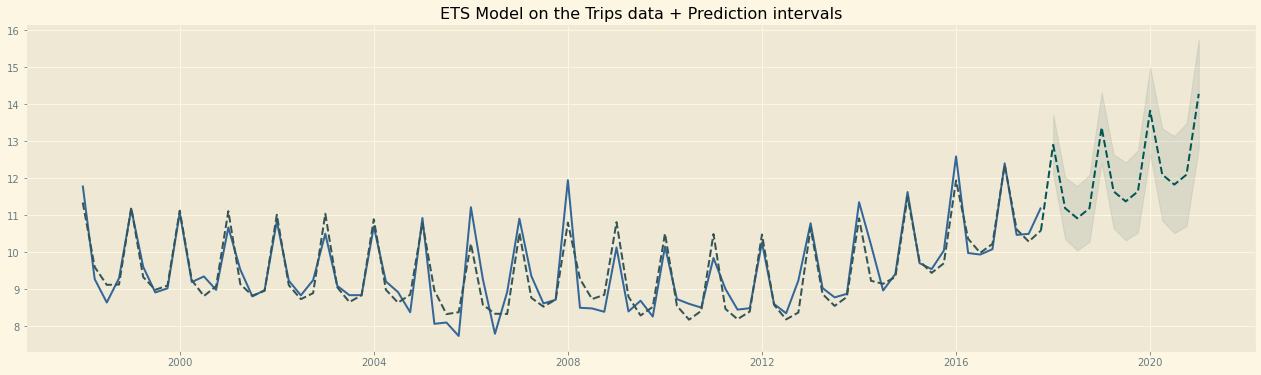

In [11]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

FORECAST_H = 12
N = aus_trips_ts.shape[0]
last_date = aus_trips_ts.index.max()

model = ETSModel(aus_trips_ts, error="add", trend="add", seasonal="add", damped_trend=False);
fit = model.fit(maxiter=10000);

# one way of forecasting is using the forecast function
forecasted = fit.forecast(FORECAST_H)

# we can add simulation intervals like that
# simulations = fit.simulate(FORECAST_H, anchor=last_date, repetitions=1000)
# lower = np.apply_along_axis(lambda x: np.quantile(x, 0.025), 1, simulations)
# upper = np.apply_along_axis(lambda x: np.quantile(x, 0.975), 1, simulations)
prediction_df = (fit
 .get_prediction(start=N, end=N + FORECAST_H, method="exact")
 .summary_frame()
)

# plot results
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series
ax.plot(aus_trips_ts, color="#336699")
ax.set_title("ETS Model on the Trips data + Prediction intervals")

# plot the fitted values
ax.plot(fit.fittedvalues, "--", color="#335555")

# plot the forecasts for the future 12 periods
ax.plot(prediction_df["mean"], "--", color="#005555")
# ax.plot(forecasted, "--", color="#005555")

# plot the confidence interval for that forecast
ax.fill_between(prediction_df.index, prediction_df.pi_lower, prediction_df.pi_upper, color='#335555', alpha=.1)

# plot a line connecting the fitted and the forecast
ax.plot(fit.fittedvalues.tail(1).append(forecasted.head(1)), "--", color="#005555")
# ax.fill_between(forecasted.index, lower, upper, color='#335555', alpha=.1)



In [12]:
from dateutil.relativedelta import relativedelta
from scipy.stats import shapiro

last_date = aus_trips_ts.index.max()
FORECAST_LENGTH = 10
forecast_periods = np.arange(4, 4 * (FORECAST_LENGTH + 1), step=3)
forecast_dates = np.array(
    [last_date + relativedelta(months=i) for i in forecast_periods]
)

jarquebera_stat, jarquebera_pval, _, _= fit.test_normality(method='jarquebera')[0]
shapiro_stat, shapiro_pval = shapiro(fit.resid.values)

print("Jarque-Bera test: statistic={:2f}, pvalue={:2f}".format(jarquebera_stat, jarquebera_pval))
print("Shapiro test: statistic={:2f}, pvalue={:2f}".format(shapiro_stat, shapiro_pval))
print("We cannot reject normality")

Jarque-Bera test: statistic=0.373401, pvalue=0.829692
Shapiro test: statistic=0.989924, pvalue=0.790429
We cannot reject normality


In [13]:
fit.test_heteroskedasticity(method="breakvar")

array([[1.5789919 , 0.24166854]])

In [14]:
N = aus_trips_ts.shape[0]
fit.get_prediction(start=N, end=N + FORECAST_H, method="exact").summary_frame()

,mean,pi_lower,pi_upper
2018-01-01,12.919973,12.111940,13.728005
2018-04-01,11.193340,10.357761,12.028920
2018-07-01,10.921180,10.052692,11.789667
2018-10-01,11.190203,10.283394,12.097012
2019-01-01,13.375530,12.425014,14.326045
2019-04-01,11.648897,10.649454,12.648340
2019-07-01,11.376737,10.323309,12.430164
2019-10-01,11.645760,10.533508,12.758012
2020-01-01,13.831086,12.655385,15.006788
2020-04-01,12.104454,10.860960,13.347948


### Exercises:
1. Consider the the number of pigs slaughtered in Victoria, available in the aus_livestock dataset.

- Use the ETS() function to estimate the equivalent model for simple exponential smoothing.
- Find the optimal values of  α  and  ℓ0 , and generate forecasts for the next four months.
- Compute a 95% prediction interval for the first forecast using  ^y±1.96s  where  s  is the standard deviation of the residuals.
- Compare your interval with the interval produced by R.

<AxesSubplot:xlabel='Date'>

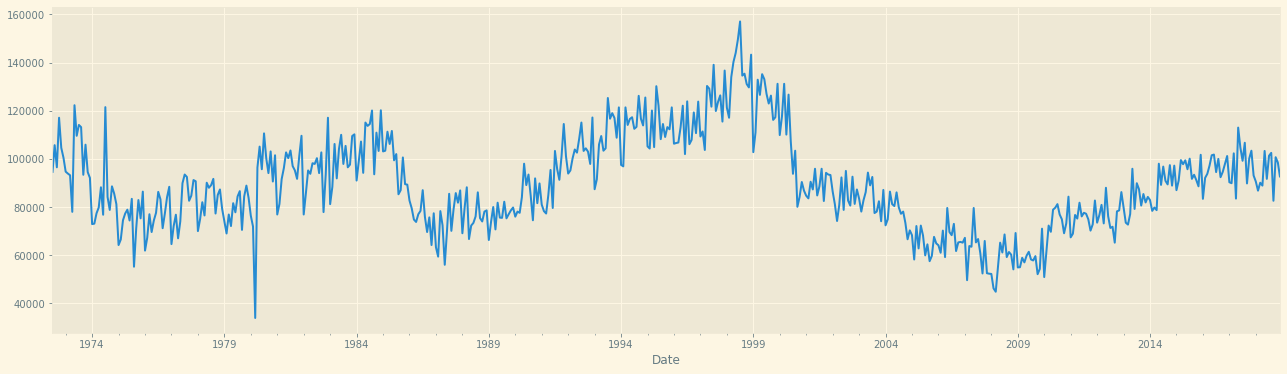

In [15]:
aus_livestock_df = load_data("aus_livestock").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year,
    Month=lambda df: df.Date.dt.month
)

is_pigs = aus_livestock_df.Animal == "Pigs"
is_victoria = aus_livestock_df.State == "Victoria"
victoria_pigs_df = aus_livestock_df[is_pigs & is_victoria]

victoria_pigs_ts = victoria_pigs_df.set_index("Date").Count
victoria_pigs_ts.plot(figsize=(22, 6))

- There's definitely a trend-cycle component
- There might be a seasonal component

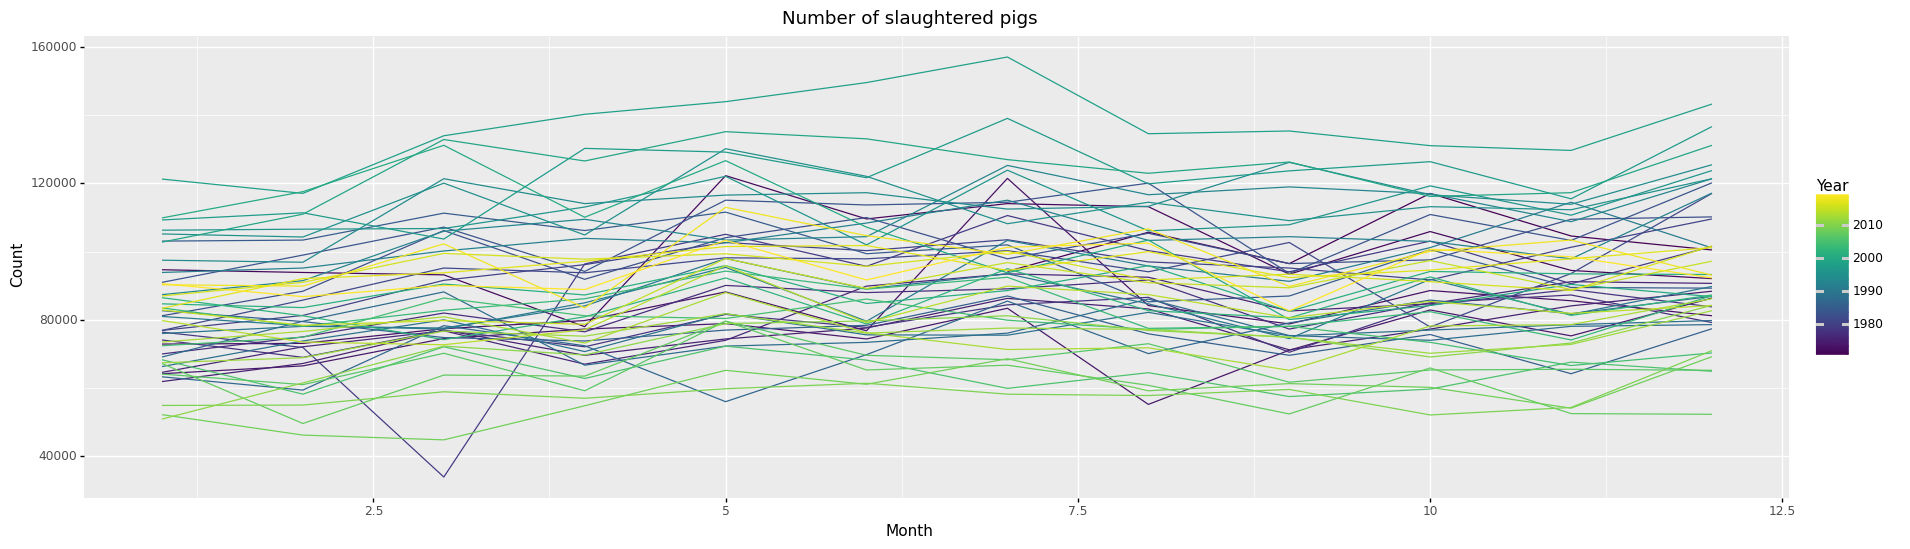

<ggplot: (8770094214301)>

In [16]:
(victoria_pigs_df
 .assign(
     Month = lambda df: df.Date.dt.month,
     Year = lambda df: df.Date.dt.year
)
 .pipe(ggplot) +
    aes(x="Month", y="Count", color="Year", group="Year") +
    geom_line() +
    ggtitle("Number of slaughtered pigs") +
    theme(figure_size=(22, 6))
)

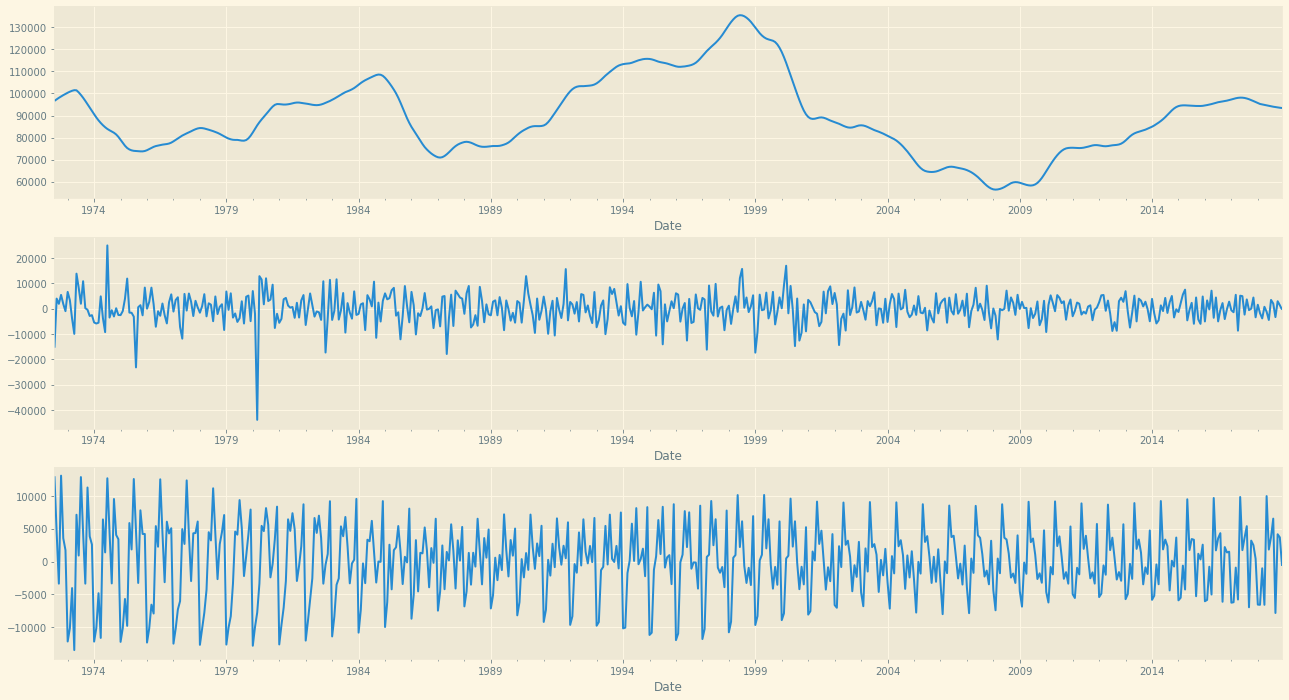

In [17]:
import matplotlib.pyplot as plt 

decomposition = STL(victoria_pigs_ts, seasonal=13).fit()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)

fig.set_figwidth(22)
fig.set_figheight(12)

# plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 12)'>

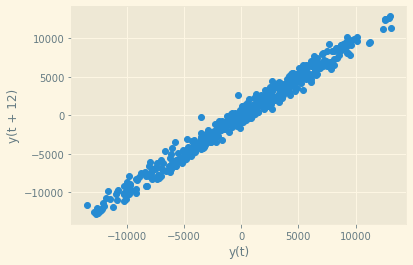

In [18]:
pd.plotting.lag_plot(decomposition.seasonal, lag=12)

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


<AxesSubplot:title={'center':'Simple Exponential Smoothing of Algerian Exports'}, xlabel='Date'>

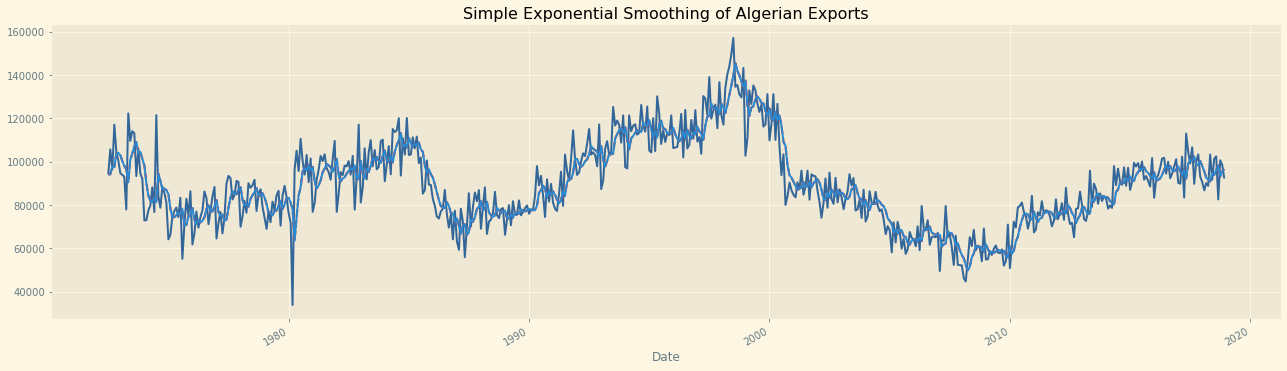

In [19]:
pigs_model = SimpleExpSmoothing(victoria_pigs_ts).fit()

fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

ax.set_title("Simple Exponential Smoothing of Algerian Exports")
ax.plot(victoria_pigs_ts, color="#336699")

# plot the forecast and the data 
ax.plot(pigs_model.fittedvalues, '--', lw=2, color='red')
# ax.plot(forecast_x, forecast_y, '--', lw=2, color='red')

pigs_model.fittedvalues.plot()

### Backtesting

In [41]:
def reverse(series):
    df = aus_trips_ts.to_frame().reset_index()
    date_vals = df.Date.values
    df['Date'] = date_vals[::-1]

    return df.set_index("Date").Trips.sort_index()

reversed_series = reverse(aus_trips_ts)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90089D+00    |proj g|=  9.88789D-01

At iterate    1    f=  1.09137D+00    |proj g|=  1.34966D+00

At iterate    2    f=  1.05612D+00    |proj g|=  2.43502D-01

At iterate    3    f=  1.03248D+00    |proj g|=  1.51100D-01

At iterate    4    f=  1.00635D+00    |proj g|=  1.56671D-01

At iterate    5    f=  9.83859D-01    |proj g|=  1.14394D-01

At iterate    6    f=  8.92884D-01    |proj g|=  1.18618D+00

At iterate    7    f=  8.28540D-01    |proj g|=  1.34793D-01

At iterate    8    f=  8.08268D-01    |proj g|=  1.06407D-01

At iterate    9    f=  7.94964D-01    |proj g|=  3.91303D-01

At iterate   10    f=  7.92323D-01    |proj g|=  4.66390D-02

At iterate   11    f=  7.91421D-01    |proj g|=  4.83305D-02

At iterate   12    f=  7.89812D-01    |proj g|=  1.20868D-01

At iterate   13    f=  7.8

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.


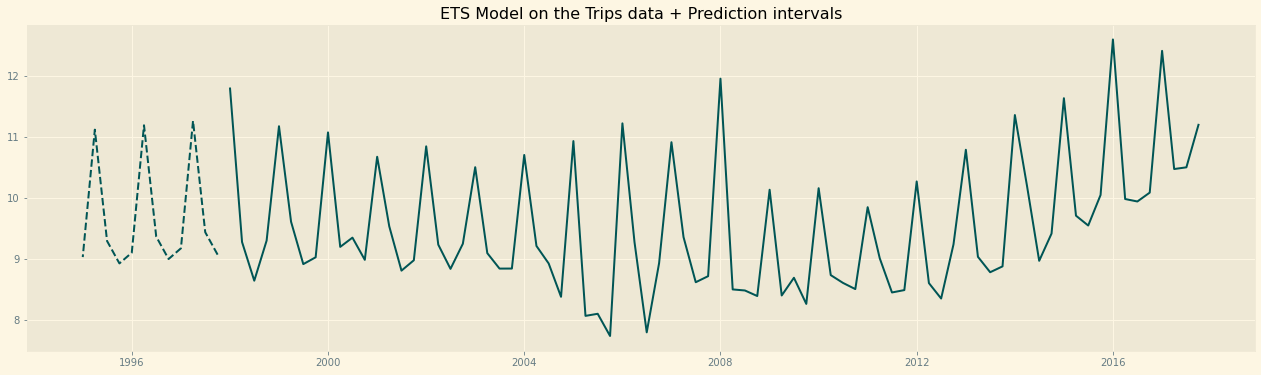

In [129]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

FORECAST_H = 12
N = reversed_series.shape[0]
last_date = reversed_series.index.max()

model = ETSModel(reversed_series, error="add", trend="add", seasonal="add", damped_trend=False);
fit = model.fit(maxiter=10000);

# one way of forecasting is using the forecast function
forecasted = fit.forecast(FORECAST_H)

# we can add simulation intervals like that
# simulations = fit.simulate(FORECAST_H, anchor=last_date, repetitions=1000)
# lower = np.apply_along_axis(lambda x: np.quantile(x, 0.025), 1, simulations)
# upper = np.apply_along_axis(lambda x: np.quantile(x, 0.975), 1, simulations)
prediction_df = (fit
 .get_prediction(start=N + 1, end=N + FORECAST_H, method="exact")
 .summary_frame()
)

from datetime import timedelta

forecast_periods

first_date = aus_trips_ts.index.min()
forecast_periods = np.arange(3, 4 * (FORECAST_LENGTH) - 1, step=3)
forecast_dates = np.array(
    [first_date - relativedelta(months=i) for i in forecast_periods]
)
prediction_df.index = forecast_dates

# # plot results
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

forecast_dates.shape

# # plot the time series
ax.plot(aus_trips_ts, color="#005555")
ax.set_title("ETS Model on the Trips data + Prediction intervals")

# # plot the forecasts for the future 12 periods
ax.plot(prediction_df["mean"], "--", color="#005555")
# ax.plot(forecasted, "--", color="#005555")

# # plot the confidence interval for that forecast
# ax.fill_between(prediction_df.index, prediction_df.pi_lower, prediction_df.pi_upper, color='#335555', alpha=.1)

# # plot a line connecting the fitted and the forecast
# ax.plot(fit.fittedvalues.tail(1).append(forecasted.head(1)), "--", color="#005555")
# ax.fill_between(forecasted.index, lower, upper, color='#335555', alpha=.1)

